<a href="https://colab.research.google.com/github/ClauCll/Curso_ML_A_Z/blob/master/Regresi%C3%B3n/Regresion_Bajas_Antiguedad_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cuantas serán las bajas voluntarias de los clientes fijos para el periodo 202009 - 202012
 

In [57]:
import pandas as pd
import numpy as np

#Gráfico
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt 
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

import gspread
from oauth2client.client import GoogleCredentials 
from google.colab import auth
# Autoriza Claudia
auth.authenticate_user()
gc = gspread.authorize (GoogleCredentials.get_application_default())

### leemos datos

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
data = pd.read_csv('/content/drive/My Drive/Dataset/BAJAS.txt',delimiter='~')
data = data[['MES_BAJA','TRIM_1','TRIM_2','TRIM_3','TRIM_4','ENTRE_1_2_ANIOS','ENTRE_3_4_ANIOS','MAS_5_ANIOS','TOTAL_BAJAS']]
data = data.groupby(['MES_BAJA']).agg({"MES_BAJA":'median',"TRIM_1": 'median',"TRIM_2": 'median',
                                "TRIM_3": 'median',"TRIM_4": 'median',  
                                "ENTRE_1_2_ANIOS": 'median',"ENTRE_3_4_ANIOS": 'median',
                                "MAS_5_ANIOS": 'median',"TOTAL_BAJAS": 'median'})
X  = data.iloc[:,:-1].values
Y  = data.iloc[:,8]
Y = Y[:,np.newaxis]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


In [73]:
data

,MES_BAJA,TRIM_1,TRIM_2,TRIM_3,TRIM_4,ENTRE_1_2_ANIOS,ENTRE_3_4_ANIOS,MAS_5_ANIOS,TOTAL_BAJAS
MES_BAJA,,,,,,,,,
1,1,31.0,22.0,21.5,271.0,727.5,399.0,19.0,1491.0
2,2,38.5,18.5,31.5,343.0,924.5,511.0,21.5,1888.5
3,3,47.5,24.0,24.5,239.5,736.0,424.0,38.0,1533.5
4,4,44.5,23.5,19.5,172.5,546.0,318.0,28.5,1152.5
5,5,56.0,20.0,24.0,202.5,545.5,313.5,21.0,1182.5
6,6,54.0,35.0,22.5,174.0,672.0,369.0,57.5,1384.0
7,7,59.5,43.5,26.5,166.0,679.5,382.5,72.5,1430.0
8,8,19.0,18.0,19.0,168.0,590.0,294.0,6.0,1114.0
9,9,26.0,19.0,20.0,142.0,498.0,316.0,10.0,1031.0


In [78]:
X[:,1]

array([31. , 38.5, 47.5, 44.5, 56. , 54. , 59.5, 19. , 26. , 29. , 35. ,
       42. ])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR

#entrenamos datos
x1 = X[:,0]
x1 = x1[:,np.newaxis]
y1 = X[:,1]
y1 = y1[:,np.newaxis]

x_train, x_test, y_train, y_test = train_test_split(x1, y1,train_size = 0.8,
                                        random_state = 0,
                                        shuffle      = True
                                    )
#escalamos los datos
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
x_train = sc_x.fit_transform(x_train)
y_train= sc_y.fit_transform(y_train)
x_test = sc_x.fit_transform(x_test)
y_test= sc_y.fit_transform(y_test)

#aplicando modelo svm
svr= SVR(kernel='rbf',degree=3, C=1.0, epsilon=0.2)
svr.fit(x_train,y_train)


In [90]:
x_valor=sc_x.inverse_transform(x_train)
y_valor= sc_y.inverse_transform(y_train)
y_predic_valor= sc_y.inverse_transform(svr.predict(x_train))
y_predic_valor

array([50.22790588, 56.20731471, 46.7959962 , 53.2532425 , 47.68568031,
       48.01223936, 57.85042515, 50.38472232, 54.42429761])

In [ ]:
y_valor

In [93]:
x_valor_t=sc_x.inverse_transform(x_test)
y_valor_t= sc_y.inverse_transform(y_test)
y_predic_valor_t= sc_y.inverse_transform(svr.predict(x_test))
y_predic_valor_t

array([57.51431081, 49.55979001, 54.71690563])

In [ ]:
y_valor_t

In [86]:
#score
print(svr.score(x_train,y_train))
print(svr.score(x_test,y_test))

0.6030973523074987
0.634170741910758


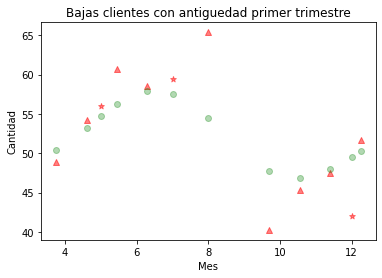

In [95]:
plt.scatter(x_valor, y_valor, c='red', marker='^', alpha=0.5)
plt.scatter(x_valor_t , y_valor_t , c='red', marker='*', alpha=0.5)
plt.scatter(x_valor, y_predic_valor, c='green', marker='o', alpha=0.3)
plt.scatter(x_valor_t , y_predic_valor_t , c='green', marker='o', alpha=0.3)
plt.xlabel('Mes')
plt.ylabel('Cantidad')
plt.title('Bajas clientes con antiguedad primer trimestre')
plt.show()